# Import

In [1]:
from sentence_transformers import SentenceTransformer, util
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import json
import math

In [2]:
assist_url = 'E:/[1]AI/july/assistment1.csv' #[change to your own path]

# 0 Read_data

In [3]:
ori_data = pd.read_csv(assist_url,low_memory=False)

In [4]:
#The skill name "Absolute Value" corresponds to two IDs, 85 and 163, and one of them needs to be deleted.
ori_data['skill_id'].replace(163, 85, inplace=True)
ori_data.head(2)
#ori_data.shape #:(525534, 30)

,order_id,assignment_id,user_id,assistment_id,problem_id,original,correct,attempt_count,ms_first_response,tutor_mode,...,hint_count,hint_total,overlap_time,template_id,answer_id,answer_text,first_action,bottom_hint,opportunity,opportunity_original
0,33022537,277618,64525,33139,51424,1,1,1,32454,tutor,...,0,3,32454,30799,NaN,26,0,NaN,1,1.0
1,33022709,277618,64525,33150,51435,1,1,1,4922,tutor,...,0,3,4922,30799,NaN,55,0,NaN,2,2.0


In [5]:
ori_data.columns

Index(['order_id', 'assignment_id', 'user_id', 'assistment_id', 'problem_id',
       'original', 'correct', 'attempt_count', 'ms_first_response',
       'tutor_mode', 'answer_type', 'sequence_id', 'student_class_id',
       'position', 'type', 'base_sequence_id', 'skill_id', 'skill_name',
       'teacher_id', 'school_id', 'hint_count', 'hint_total', 'overlap_time',
       'template_id', 'answer_id', 'answer_text', 'first_action',
       'bottom_hint', 'opportunity', 'opportunity_original'],
      dtype='object')

# 1 Filtering, De-duplication and Time Sorting

In [5]:
# Filtering
select_columns = ['user_id','problem_id', 'skill_id', 'correct','ms_first_response']
sel_data = ori_data[select_columns]
sel_data.head()
#sel_data.shape #:(525534, 5)

,user_id,problem_id,skill_id,correct,ms_first_response
0,64525,51424,1.0,1,32454
1,64525,51435,1.0,1,4922
2,70363,51444,1.0,0,25390
3,70363,51395,1.0,1,4859
4,70363,51481,1.0,0,19813


In [6]:
# dropna
sel_data_copy = sel_data.copy()
sel_data_copy.dropna(inplace=True)
sel_data = sel_data_copy 
sel_data.shape #shape: (459208, 5)

(459208, 5)

In [7]:
# drop_duplicates
sel_data = sel_data.drop_duplicates().reset_index(drop=True)
# reset_index
sel_data = sel_data.reset_index(drop=True)
#sel_data.shape #：(337998, 5)

In [8]:
# Group by' user_id' and sort by' ms_first_response' within each group
sel_data_sorted = sel_data.groupby('user_id').apply(lambda x: x.sort_values('ms_first_response')).reset_index(drop=True)
sel_data_sorted.head() #shape #：(337998, 5)

,user_id,problem_id,skill_id,correct,ms_first_response
0,14,91127,13.0,0,2212
1,14,91144,13.0,0,3426
2,14,93415,2.0,0,8244
3,14,93415,70.0,0,8244
4,14,93415,37.0,0,8244


# 2.1 Remove students whose answers are less than or equal to 14 times

In [9]:
# all students
stu_list = sel_data_sorted['user_id'].value_counts().index.tolist()
#len(stu_list) #:4163

In [10]:
# students who answered less than or equal to 14 times
stu_times = sel_data_sorted['user_id'].value_counts()
rare_stu = stu_times[stu_times <= 14].index.tolist()
len(rare_stu) #:1535

1535

In [11]:
# remove students who answered less than or equal to 14 times
sel_data_sorted_1 = sel_data_sorted[~sel_data_sorted['user_id'].isin(rare_stu)]
sel_data_sorted_1 = sel_data_sorted_1.reset_index(drop=True)
#sel_data_sorted_1.shape #：(327320, 5)
#学生数量：2628

# 2.2 Remove questions answered less than or equal to 2 times

In [12]:
# all questions
exer_list = sel_data_sorted_1['problem_id'].value_counts().index.tolist()
#len(exer_list) #:17684

In [13]:
# questions answered less than or equal to 2 times.
exer_times = sel_data_sorted_1['problem_id'].value_counts()
rare_exer = exer_times[exer_times <= 2].index.tolist()
#len(rare_exer) #:2523

In [14]:
# remove them
filtered_sel_data_sorted = sel_data_sorted_1[~sel_data_sorted_1['problem_id'].isin(rare_exer)]
filtered_sel_data_sorted = filtered_sel_data_sorted.reset_index(drop=True)
#filtered_sel_data_sorted.shape #：(323665, 5)

In [15]:
filtered_sel_data_sorted['skill_id'] = filtered_sel_data_sorted['skill_id'].astype(int)

In [16]:
filtered_sel_data_sorted.head()

,user_id,problem_id,skill_id,correct,ms_first_response
0,14,91127,13,0,2212
1,14,91144,13,0,3426
2,14,93415,2,0,8244
3,14,93415,70,0,8244
4,14,93415,37,0,8244


# 3 Mapping students, problems and knowledge points

In [17]:
# Get a list of students, questions and knowledge points.
stu_list = filtered_sel_data_sorted['user_id'].value_counts().index.tolist()
#len(stu_list)#: 2627
problem_list = filtered_sel_data_sorted['problem_id'].value_counts().index.tolist()
#len(problem_list)#: 15161
kc_list = filtered_sel_data_sorted['skill_id'].value_counts().index.tolist() 
#len(kc_list)#: 116

In [18]:
# initialize dic
stu_get_ID = {}
plm_get_ID = {}
kc_get_ID = {}

stu_get_oriID = {}
plm_get_oriID = {}
kc_get_oriID = {}

In [19]:
# mapping
for index,value in enumerate(stu_list):
    stu_get_ID[value] = index
    stu_get_oriID[index] = value
for index,value in enumerate(problem_list):
    plm_get_ID[value] = index
    plm_get_oriID[index] = value
for index,value in enumerate(kc_list):
    kc_get_ID[value] = index
    kc_get_oriID[index] = value

In [20]:
# save
with open('ass_stu_get_ID.json', 'w', encoding='utf-8') as f:
    json.dump(stu_get_ID, f, ensure_ascii=False, indent=4)
with open('ass_plm_get_ID.json', 'w', encoding='utf-8') as f:
    json.dump(plm_get_ID, f, ensure_ascii=False, indent=4)
with open('ass_kc_get_ID.json', 'w', encoding='utf-8') as f:
    json.dump(kc_get_ID, f, ensure_ascii=False, indent=4)

In [21]:
filtered_sel_data_sorted.head()

,user_id,problem_id,skill_id,correct,ms_first_response
0,14,91127,13,0,2212
1,14,91144,13,0,3426
2,14,93415,2,0,8244
3,14,93415,70,0,8244
4,14,93415,37,0,8244


In [22]:
# filtered_sel_data_sorted -> mapping_df
# user_id   problem_id   skill_id   correct
mapping_df = filtered_sel_data_sorted.copy() 
mapping_df['user_id'] = filtered_sel_data_sorted['user_id'].map(stu_get_ID)
mapping_df['problem_id'] = filtered_sel_data_sorted['problem_id'].map(plm_get_ID)
mapping_df['skill_id'] = filtered_sel_data_sorted['skill_id'].map(kc_get_ID)
mapping_df.head(5)

,user_id,problem_id,skill_id,correct,ms_first_response
0,1357,6791,21,0,2212
1,1357,11418,21,0,3426
2,1357,738,17,0,8244
3,1357,738,4,0,8244
4,1357,738,33,0,8244


In [23]:
mapping_df.loc[mapping_df['user_id'] == 0]

,user_id,problem_id,skill_id,correct,ms_first_response
111562,0,1674,11,0,1141
111563,0,1674,9,0,1141
111564,0,712,9,0,1204
111565,0,712,11,0,1204
111566,0,8963,18,0,1373
...,...,...,...,...,...
112845,0,585,9,0,797109
112846,0,585,11,0,797109
112847,0,6298,39,0,857974
112848,0,17,9,0,1867331


# 4 Generate JSON file

In [24]:
# user_id   problem_id   skill_id   correct   ms_first_response

In [25]:
# Get all the knowledge points corresponding to each question id
problem_skill_group_dic = {}
problem_list = mapping_df['problem_id'].value_counts().index.tolist()
for index, p_id in enumerate(problem_list):
    p_float_list = mapping_df.loc[mapping_df['problem_id'] == p_id]['skill_id'].value_counts().index.tolist()
    p_int_list = list(map(int, p_float_list))
    problem_skill_group_dic[p_id] = p_int_list

In [26]:
# save
def save_dict_to_txt(dictionary, filename):
    with open(filename, 'w', encoding='utf-8') as file:
        json.dump(dictionary, file, ensure_ascii=False, indent=4)
save_dict_to_txt(problem_skill_group_dic, 'ass_q_kc_dic.txt')

In [24]:
# Complete all the knowledge points corresponding to each question.
res_df = mapping_df.copy()
res_df['skill_id'] = mapping_df['problem_id'].map(problem_skill_group_dic)
res_df['skill_id'] = res_df['skill_id'].apply(lambda x: ','.join([str(item) for item in x]) if isinstance(x, list) else x)
res_df.head(6)
#res_df.shape #:(323665, 5)

,user_id,problem_id,skill_id,correct,ms_first_response
0,1357,6791,21,0,2212
1,1357,11418,21,0,3426
2,1357,738,"17,4,33",0,8244
3,1357,738,"17,4,33",0,8244
4,1357,738,"17,4,33",0,8244
5,1357,8993,21,0,9236


In [25]:
# drop defore
res_df.loc[res_df.user_id == 0]

,user_id,problem_id,skill_id,correct,ms_first_response
111562,0,1674,"9,11",0,1141
111563,0,1674,"9,11",0,1141
111564,0,712,"9,11",0,1204
111565,0,712,"9,11",0,1204
111566,0,8963,18,0,1373
...,...,...,...,...,...
112845,0,585,"9,11",0,797109
112846,0,585,"9,11",0,797109
112847,0,6298,39,0,857974
112848,0,17,"11,9",0,1867331


In [26]:
# Delete the redundant answer records split by knowledge points.
res_df = res_df.drop_duplicates().reset_index(drop=True)
#res_df.shape #：(269663, 5)

In [27]:
# drop
res_df.loc[res_df.user_id == 0]

,user_id,problem_id,skill_id,correct,ms_first_response
91068,0,1674,"9,11",0,1141
91069,0,712,"9,11",0,1204
91070,0,8963,18,0,1373
91071,0,1636,"9,11",0,1375
91072,0,9473,37,0,1420
...,...,...,...,...,...
92117,0,276,10,1,756796
92118,0,3491,39,0,794504
92119,0,585,"9,11",0,797109
92120,0,6298,39,0,857974


In [29]:
# Generate JSON file
initial_json_list = []
Response_records_all_students = []

for stu_id in stu_get_oriID:
    df_1 = res_df.loc[res_df['user_id'] == stu_id]
    logs_list = []
    logs_num = len(df_1);
    for index, row in df_1.iterrows():
        p_id = row['problem_id']
        p_code_str = row['skill_id'].split(',')
        p_code = [int(item) for item in p_code_str]
        if len(p_code) >= 1:
            logs_item = {"exer_id": p_id, "score": row['correct'], "knowledge_code": p_code}
            logs_list.append(logs_item)
    initial_json_item = {
        "stu_id": stu_id,
        "log_num": len(logs_list),
        "logs":logs_list
    }
    Response_records_all_students.append(len(logs_list))
    initial_json_list.append(initial_json_item)

In [30]:
# Overview of student records
Response_records = sum(Response_records_all_students)
Response_records_per_students = Response_records / len(Response_records_all_students)
print("Response_records:", Response_records)
print("Response_records_per_students:", Response_records_per_students)

Response_records: 269663
Response_records_per_students: 102.65055196041112


In [31]:
# Save JSON file 
def convert_int64_to_int(obj):
    if isinstance(obj, np.int64):
        return int(obj)
    raise TypeError
initial_json = json.dumps(initial_json_list, default=convert_int64_to_int, ensure_ascii=False, indent=4, separators=(',', ': '))
filename = 'C:/Users/Lenovo/Desktop/Assist09_s15_p2_logs.json' #[change to your own path]
with open(filename, 'w', encoding='utf-8') as file:
    file.write(initial_json)

# 5 Generate knowledge graph

## 5-1 Generating dictionary: skill_id -> skill_name

In [24]:
# stu_get_ID
# plm_get_ID
# kc_get_ID

# stu_get_oriID
# plm_get_oriID
# kc_get_oriID

In [25]:
# user_id   problem_id   skill_id   correct   ms_first_response

In [26]:
ori_skid_skname_df = ori_data[['skill_id','skill_name']]
ori_skid_skname_df = ori_skid_skname_df.drop_duplicates().reset_index(drop=True)
ori_skid_skname_df.dropna(subset=['skill_id'], inplace=True)
ori_skid_skname_df.head()
#ori_skid_skname_df.shape  #:(122, 2))

,skill_id,skill_name
0,1.0,Box and Whisker
1,2.0,Circle Graph
2,4.0,Histogram as Table or Graph
3,5.0,Number Line
4,8.0,Scatter Plot


In [27]:
lost_name_skid = ori_skid_skname_df[ori_skid_skname_df.isnull().any(axis = 1) == True]['skill_id'].tolist()
lost_map = {}
for index, value in enumerate(lost_name_skid):
    if math.isnan(value) == False:
        lost_map[value] = 'unknown_skill_' + str(index)

In [28]:
oriID_NAME_dic = {}
for index, row in ori_skid_skname_df.iterrows(): 
    oriID_NAME_dic[row['skill_id']] = str(row['skill_name'])
    
for key, value in lost_map.items():
    oriID_NAME_dic[key] = value
#oriID_NAME_dic

In [29]:
kc_get_NAME = {}
for key, value in kc_get_oriID.items():
    kc_get_NAME[key] = oriID_NAME_dic[value]
#kc_get_NAME

## 5-2 SentenceTransformer -> semantic similarity

In [30]:
model = SentenceTransformer('E:/[model]big_model/all-MiniLM-L6-v2') #[need download model and change to your own path]

In [31]:
# kcid-kc_tensor
KCID_tensor_dic = {}
for kcid in kc_get_NAME:
    if kc_get_NAME[kcid] != "nan":
        embedding = model.encode(kc_get_NAME[kcid], convert_to_tensor=True)
        KCID_tensor_dic[kcid] = embedding

In [32]:
# Similarity matrix
mx_size = len(kc_get_NAME)
s_matrix = np.zeros((mx_size, mx_size))

for kcid1 in KCID_tensor_dic:
    t1 = KCID_tensor_dic[kcid1]
    for kcid2 in KCID_tensor_dic:
        if(kcid1 == kcid2):
            s_matrix[kcid1][kcid2] = 0
            continue
        t2 = KCID_tensor_dic[kcid2]
        s_matrix[kcid1][kcid2] = util.pytorch_cos_sim(t1, t2)

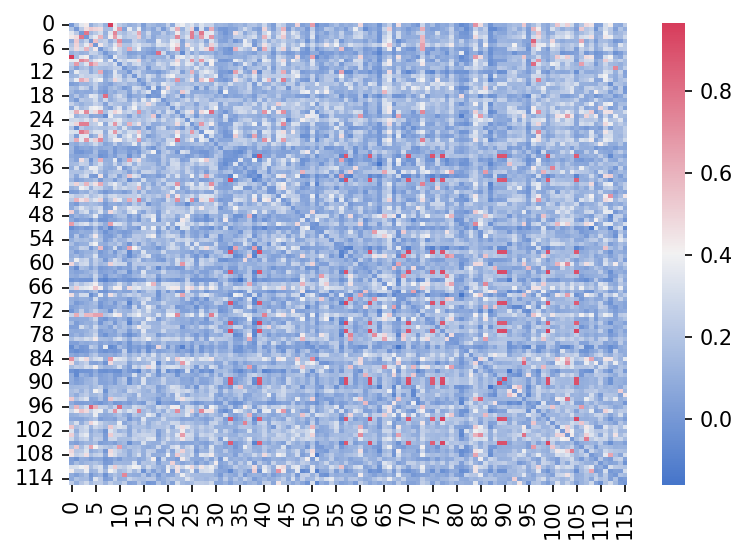

In [33]:
# Heat map analysis
plt.figure(dpi=150, figsize=(6, 4))
sns.heatmap(
    data=s_matrix,
    cmap=sns.diverging_palette(255, 5, as_cmap=True),
)
plt.savefig('skill_heatmap_before.png')

In [34]:
# Generating similarity binary group
s_triple_list = []
for i in range(mx_size):
    for j in range(mx_size):
        if s_matrix[i][j] > 0.4:
            triple_item = [i,j]
            s_triple_list.append(triple_item)
            triple_item = [j,i]
            s_triple_list.append(triple_item)
len(s_triple_list) #:1604

1604

In [35]:
s_triple_df = pd.DataFrame(s_triple_list, columns=['Subject','Object'])

## 5-3 Analysis of Co-occurrence of Knowledge Points

In [36]:
p_group_list = []
for key, value in problem_skill_group_dic.items():
    coo_list = value
    if len(coo_list) >= 2:
        p_group_list.append(coo_list)=
len(p_group_list) #:2823

2823

In [37]:
# Co-occurrence matrix
mx_size = len(kc_get_NAME) #mx_size ： 80

m_matrix = np.zeros((mx_size, mx_size))
for p_group in p_group_list:
    for i in range(0,len(p_group)):
        for j in range(i+1,len(p_group)):
            m_matrix[p_group[i],p_group[j]] += 1;
            m_matrix[p_group[j],p_group[i]] += 1;

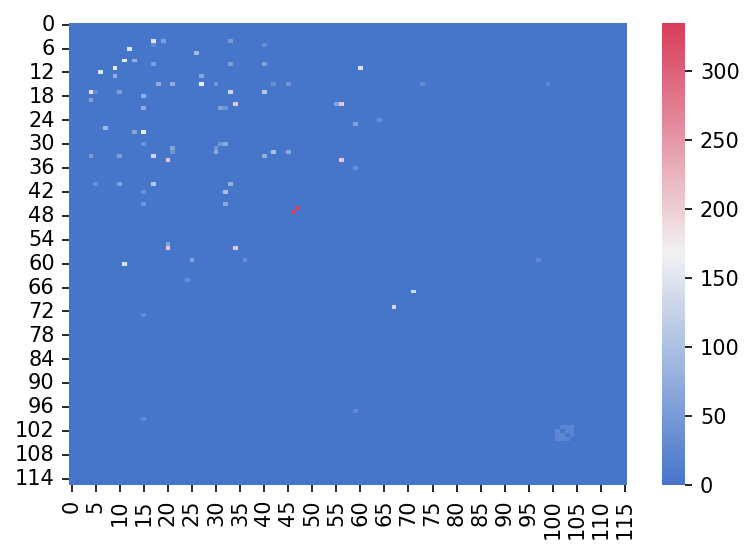

In [38]:
# Heat map analysis
plt.figure(dpi=150, figsize=(6, 4))
sns.heatmap(
    data=m_matrix,
    cmap=sns.diverging_palette(255, 5, as_cmap=True),
)
plt.savefig('skill_group_heatmap.png')

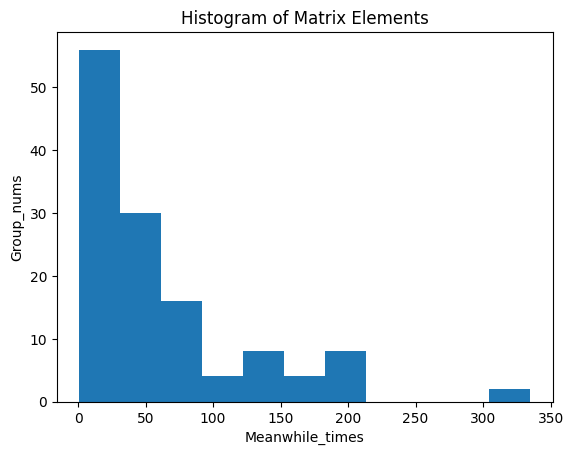

In [65]:
# Histogram analysis
freq_list = []
for line in m_matrix:
    for item in line:
        if item > 0:
            freq_list.append(item)
freq_array = np.array(freq_list)
plt.hist(freq_array, bins=11)
plt.xlabel('Meanwhile_times')
plt.ylabel('Group_nums')
plt.title('Histogram of Matrix Elements')
plt.savefig('skill_meanwhile_frequency.png')
plt.show()

In [66]:
# Generating binary group
m_triple_list = []
for i in range(mx_size):
    for j in range(mx_size):
        if m_matrix[i][j] > 0:
            triple_item = [i,j]
            m_triple_list.append(triple_item)
            triple_item = [j,i]
            m_triple_list.append(triple_item)
len(m_triple_list) #:256

256

In [67]:
m_triple_df = pd.DataFrame(m_triple_list, columns=['Subject','Object'])

## 2-4 Knowledge graph file

In [68]:
# s_triple_df
# m_triple_df
# 'Subject','Object'

In [69]:
kg_df = pd.concat([s_triple_df, s_triple_df], ignore_index=True)
kg_df = kg_df.drop_duplicates()
kg_df.head(3)
#kg_df.shape #:(802, 2)

,Subject,Object
0,0,3
1,3,0
2,0,8


In [71]:
# Save
kg_df.to_csv('C:/Users/Lenovo/Desktop/Assist09_s15_p2_graph.txt', sep='\t', index=False, header=False) #[change to your own path]